# GradCAM - Gradient Class Activation Map

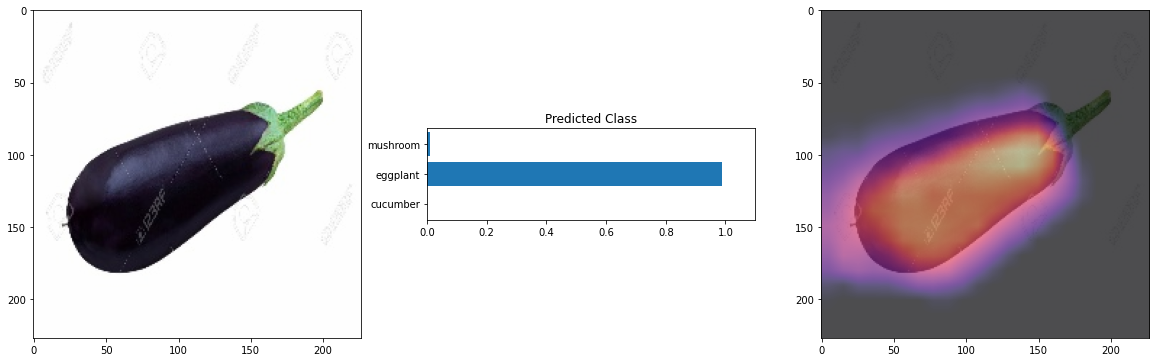

In [1]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (193/193), 2.59 MiB | 12.56 MiB/s, done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-km7y8dek
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-km7y8dek
  Resolved https://github.com/albumentations-team/albumentations to commit 92291ee13fcc80fb963de1327ac049c7b853a962
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for albumentations: filename=albumentations-2.0.5-py3-none-any.whl size=290588 sha256=f7a0fb998274711c54b269992c7644a25d111ac3cda1edb97754fb443916b33c
  Stored in directory: /tmp/pip-ephem-

# Imports

In [2]:
import sys
sys.path.append('/content/GradCAM-Dataset')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [4]:
CSV_FILE = '/content/GradCAM-Dataset/train.csv'
DATA_DIR = '/content/GradCAM-Dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
LR = 0.001
EPOCHS = 20

In [5]:
data = pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [6]:
# cucumber - 0, eggpant - 1, mushroom - 2
train_df, valid_df = train_test_split(data, test_size=0.2, random_state=42)

# Augmentations

In [7]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

valid_augs = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Load Image Dataset

In [8]:
trainset = utils.ImageDataset(train_df, data_dir = DATA_DIR, augs = train_augs)
validset = utils.ImageDataset(valid_df, data_dir = DATA_DIR, augs = valid_augs)

Text(0.5, 1.0, 'eggplant')

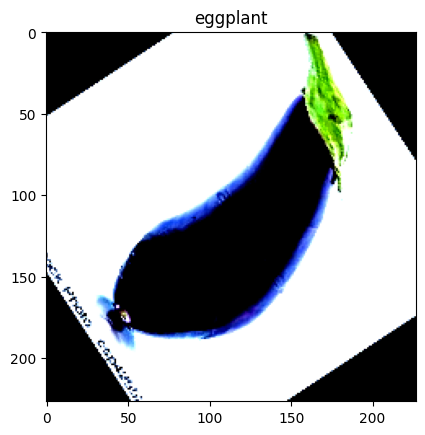

In [9]:
image, label = trainset[21] # (c, h, v) => (h, w, c)

class_list = ['cucumber', 'eggplant', 'mushroom']

plt.imshow(image.permute(1,2,0))
plt.title(class_list[label])

In [10]:
print(f"No. of examples in the {len(trainset)}")
print(f"No. of examples in the {len(validset)}")

No. of examples in the 148
No. of examples in the 38


# Load Dataset into Batches

In [11]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [12]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [13]:
for images, labels in trainloader:
  break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


# Create Model

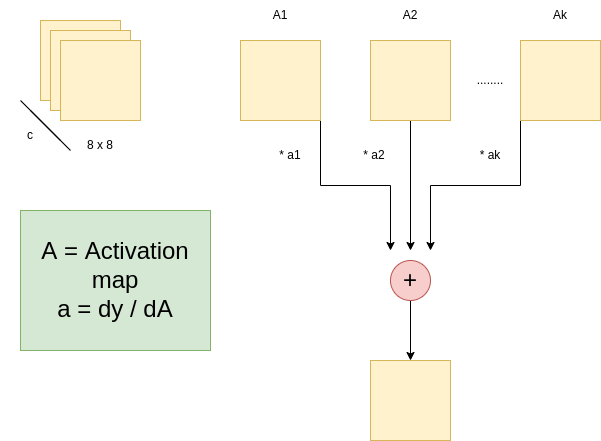

In [30]:
class ImageModel(nn.Module):

    def __init__(self):
        super(ImageModel, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
        )

        self.maxpool = nn.MaxPool2d(kernel_size=(4, 4), stride=2)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6400, out_features=2048),
            nn.ReLU(),
            nn.Linear(2048, 3)
        )

        self.gradient = None

    def activations_hook(self, grad):
        self.gradient = grad

    def forward(self, images):
        x = self.feature_extractor(images) # activation_map

        x.register_hook(self.activations_hook)
        x = self.maxpool(x)
        x = self.classifier(x)

        return x

    def get_activations_gradient(self): # a1, a2, a3,...ak
        return self.gradient

    def get_activations(self, x): # A1, A2, A3,...AK
        return self.feature_extractor(x)


In [31]:
model = ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [32]:
def train_fn(dataloader, model, optimizer, criterion):

    model.train()
    total_loss = 0.0

    for images, labels in tqdm(dataloader): # Changed 'label' to 'labels'
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [33]:
def eval_fn(dataloader, model, criterion):

    model.eval()
    total_loss = 0.0

    for image, label in tqdm(dataloader):
        images = image.to(DEVICE) # Changed 'images' to 'image' to unpack the image from the dataloader
        labels = label.to(DEVICE) # Changed 'labels' to 'label' to unpack the label from the dataloader

        logits = model(images)
        loss = criterion(logits, labels)

        total_loss += loss.item()

    return total_loss / len(dataloader)

# Training Loop

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

In [35]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer, criterion)
  valid_loss = eval_fn(validloader, model, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_weights.pt')
    best_valid_loss = valid_loss

    print ("SAVED_WEIGHTS_SUCCESS")

print(f"EPOCH : {i + 1} TRAIN LOSS : {train_loss} VALID LOSS : {valid_loss}")

100%|██████████| 3/3 [00:00<00:00, 42.43it/s]


SAVED_WEIGHTS_SUCCESS


100%|██████████| 3/3 [00:00<00:00, 43.85it/s]


SAVED_WEIGHTS_SUCCESS


100%|██████████| 3/3 [00:00<00:00, 46.82it/s]


SAVED_WEIGHTS_SUCCESS


100%|██████████| 3/3 [00:00<00:00, 45.64it/s]


SAVED_WEIGHTS_SUCCESS


100%|██████████| 3/3 [00:00<00:00, 46.27it/s]


SAVED_WEIGHTS_SUCCESS


100%|██████████| 3/3 [00:00<00:00, 35.01it/s]


SAVED_WEIGHTS_SUCCESS


100%|██████████| 3/3 [00:00<00:00, 41.69it/s]


SAVED_WEIGHTS_SUCCESS


100%|██████████| 3/3 [00:00<00:00, 43.57it/s]

EPOCH : 20 TRAIN LOSS : 0.05157856562291272 VALID LOSS : 0.20808602621157965


# Get GradCAM

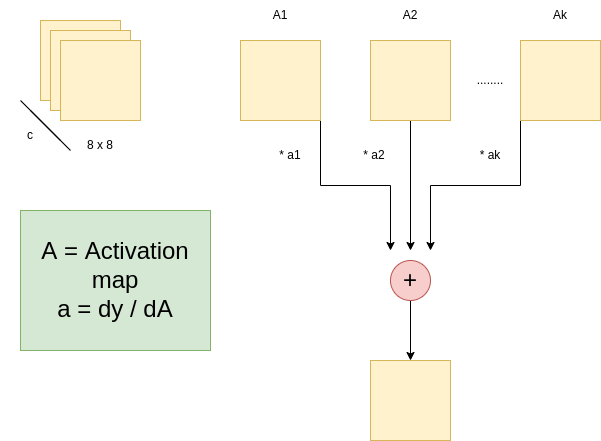

In [40]:
def get_gradcam(model, image, label, size):
  label.backward()
  gradients = model.get_activations_gradient()
  pooled_gradients = torch.mean(gradients, dim = [0, 2, 3]) #a1, a2...ak
  activations = model.get_activations(image).detach() #A1,A2,., Ak

  for i in range(activations.shape[1]):
    activations[:, i,:, :] *= pooled_gradients[i]

  heatmap = torch.mean(activations, dim = 1).squeeze().cpu()
  heatmap = nn.ReLU()(heatmap)
  heatmap /= torch.max(heatmap)
  heatmap = cv2.resize(heatmap.numpy(),(size, size))

  return heatmap

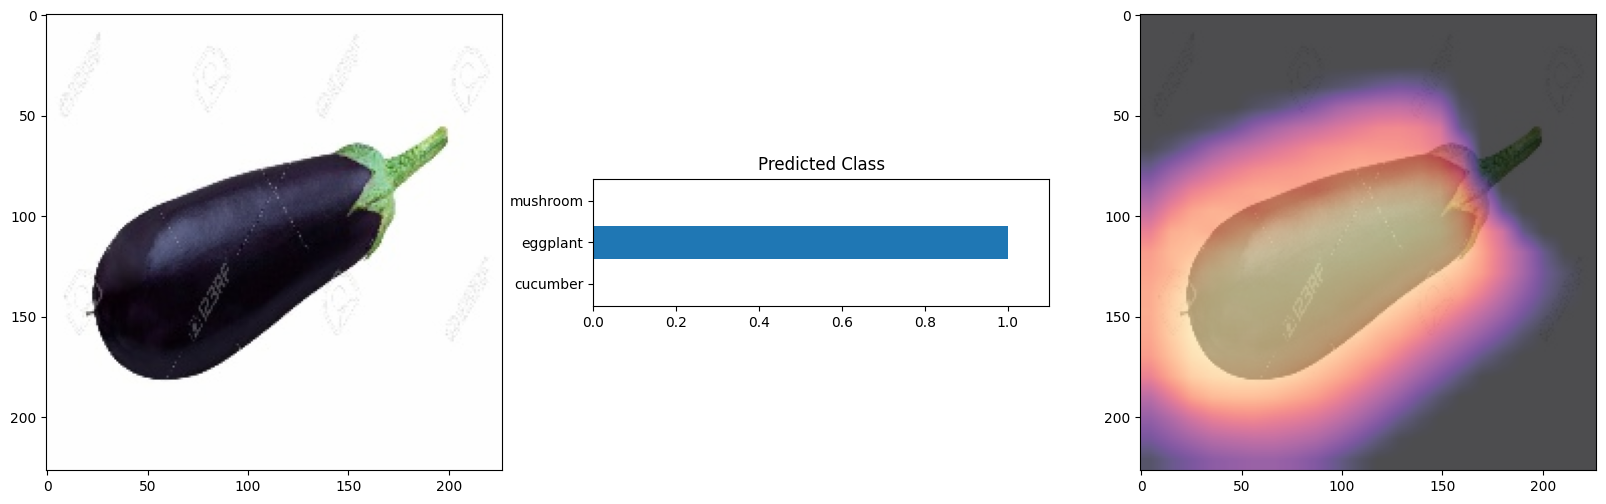

In [41]:
image, label = validset[4]

denorm_image = image.permute(1, 2, 0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456,0.406))

image = image.unsqueeze(0).to(DEVICE)

pred = model(image)
heatmap = get_gradcam(model, image, pred[0][1], size = 227)
utils.plot_heatmap(denorm_image, pred, heatmap)